In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, roc_auc_score, auc

from catboost import CatBoostClassifier
from catboost import Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
global SEED

SEED = 12
np.random.seed(SEED)

# Загрузим данные и проведем небольшой EDA

In [3]:
main_path = '/home/roman/Документы/AmazonRecomendationSystem'

In [4]:
data = pd.read_csv(os.path.join(main_path, 'data/processed/tonality_embeded_dataset.csv')).drop(['Unnamed: 0'], axis=1)

In [5]:
main_components = pd.concat([
                      pd.DataFrame(PCA(n_components=2).fit_transform(data),
                      columns=['Component 1', 'Component 2']),
                      data['target']
                      ], axis=1)

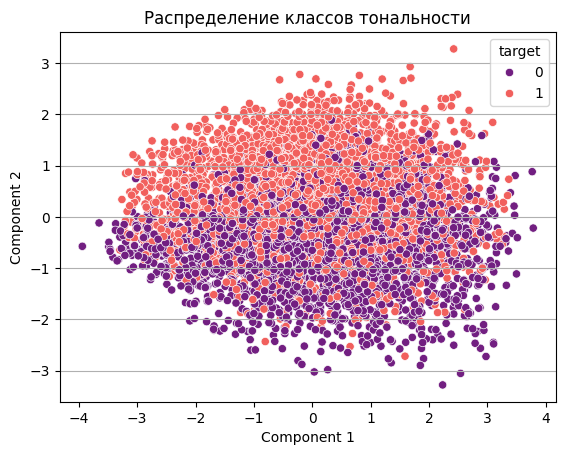

In [6]:
sns.scatterplot(
    data=main_components,
    x=main_components['Component 1'],
    y=main_components['Component 2'],
    hue='target',
    palette='magma'    
)

plt.title('Распределение классов тональности')
plt.grid(axis='y')
plt.show()

In [7]:
labels, counts = np.unique(main_components['target'], return_counts=True)
print(f"""
Распределение классов:
    -Класс: {labels[0]}; Колличество значений: {counts[0]}
    -Класс: {labels[1]}; Колличество значений: {counts[1]}
""")


Распределение классов:
    -Класс: 0; Колличество значений: 3310
    -Класс: 1; Колличество значений: 3610



# Подготовим выборки для моделирования

In [8]:
def split_indexes(
    indexes,
    test_size=0.2,
    val_size=0.2,
    stratify=None,
):
    # сами сформируем разметки для выборок
    np.random.seed(SEED)
    train_size = 1 - test_size - val_size
    assert np.round(train_size + test_size + val_size, 1) == 1.0    
    n_samples = len(indexes)

    if stratify is not None:
        stratify = np.array(stratify)
        classes, counts = np.unique(stratify, return_counts=True)
        train_idx, val_idx, test_idx = [], [], []

        for cls, count in zip(classes, counts):
            # индексы текущего класса
            cls_idx = np.where(stratify == cls)[0]

            # случайно разбиваем их на train/val/test
            np.random.shuffle(cls_idx)
            n_val = int(count * val_size)
            n_test = int(count * test_size)

            val_idx.extend(cls_idx[:n_val])
            test_idx.extend(cls_idx[n_val : n_val + n_test])
            train_idx.extend(cls_idx[n_val + n_test :])

    else:
        idx = np.arange(n_samples)
        np.random.shuffle(idx)

        n_val = int(n_samples * val_size)
        n_test = int(n_samples * test_size)

        val_idx = idx[:n_val]
        test_idx = idx[n_val : n_val + n_test]
        train_idx = idx[n_val + n_test :]

    return train_idx, test_idx, val_idx

In [9]:
train_idx, test_idx, val_idx = split_indexes(
    np.array(data.index),
    test_size=0.3,
    val_size=0.1,
    stratify=data['target']
)

In [10]:
sample = []

for i in data.index:
    if i in train_idx: sample.append('TRAIN')
    elif i in test_idx: sample.append('TEST')
    else: sample.append('VAL')

In [11]:
assert len(train_idx) + len(test_idx) + len(val_idx) == len(sample)

In [12]:
data = pd.concat([
    data,
    pd.DataFrame(sample, columns=['Sample'])
], axis=1)

In [13]:
train = data[data['Sample'] == 'TRAIN']
test = data[data['Sample'] == 'TEST']
val = data[data['Sample'] == 'VAL']

# Построим модели

## Логистическая регрессия

In [14]:
# Пайплайн с масштабированием (важно для регуляризации)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

In [15]:
param_grid = {
    'model__penalty': ['l1', 'l2'],  # тип регуляризации
    'model__C': [0.001, 0.003, 0.01, 0.1, 0.5, 0.9, 1.0],  # сила регуляризации
    'model__class_weight': [None, 'balanced'],  # балансировка классов
}

In [16]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc'
)


grid_search.fit(
    train.drop(['target', 'Sample'], axis=1),
    train['target']
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'model__C': [0.001, 0.003, 0.01, 0.1, 0.5, 0.9, 1.0],
                         'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [17]:
params = {param[param.find('_') + 2:] for param in grid_search.best_params_.keys()}

logistic_regression = LogisticRegression()
logistic_regression.fit(
    train.drop(['target', 'Sample'], axis=1),
    train['target']
)

LogisticRegression()

## CatBoost

In [18]:
train_pool = Pool(train.drop(['target', 'Sample'], axis=1), train['target'])
test_pool = Pool(test.drop(['target', 'Sample'], axis=1), test['target']) 
val_pool = Pool(val.drop(['target', 'Sample'], axis=1), val['target'])

In [19]:
boost_params = {
    'iterations': 1000,                 # Можно уменьшить, если хватает early_stopping
    'learning_rate': 0.03,              # Средняя скорость (можно 0.03 - 0.1)
    'depth': 6,                         # Неглубокая модель для избежания переобучения
    'l2_leaf_reg': 1.0,                 # Усиленная регуляризация (т.к. много фич)
    'early_stopping_rounds': 30,        # Ранняя остановка
    'use_best_model': True,             # Сохраняет лучшую модель                                
    'random_seed': SEED,                # Фиксация случайности
    'auto_class_weights': 'Balanced',   # Или scale_pos_weight вручную
    'verbose': 200,
    'feature_border_type': 'GreedyLogSum',  # Улучшает обработку числовых фич
    'rsm': 0.8,                         # Использовать 80% случайных фич в каждом дереве (аналог colsample_bylevel)
    'loss_function': 'Logloss',          # Для бинарной классификации
    'bootstrap_type': 'Bayesian',        # Лучше для стабильности
    'sampling_frequency': 'PerTreeLevel', # Чаще обновлять веса
    'min_data_in_leaf': 3,               # Минимум 3 наблюдения в листе
    'eval_metric': 'AUC'
}

In [20]:
boosting = CatBoostClassifier(**boost_params)
boosting.fit(train_pool, eval_set=test_pool)

0:	test: 0.7837713	best: 0.7837713 (0)	total: 103ms	remaining: 1m 43s
200:	test: 0.8918561	best: 0.8918561 (200)	total: 11.7s	remaining: 46.4s
400:	test: 0.8996094	best: 0.8996112 (399)	total: 23.4s	remaining: 34.9s
600:	test: 0.9022009	best: 0.9022009 (600)	total: 35s	remaining: 23.2s
800:	test: 0.9041137	best: 0.9041341 (797)	total: 46.6s	remaining: 11.6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9044437563
bestIteration = 835

Shrink model to first 836 iterations.


# Сравним качество и сохраним модели

In [21]:
logreg_train_pred = roc_auc_score(logistic_regression.predict(train.drop(['target', 'Sample'], axis=1)), train['target'])
logreg_test_pred = roc_auc_score(logistic_regression.predict(test.drop(['target', 'Sample'], axis=1)), test['target'])
logreg_val_pred = roc_auc_score(logistic_regression.predict(val.drop(['target', 'Sample'], axis=1)), val['target'])

catboost_train_pred = roc_auc_score(boosting.predict(train_pool), train['target'])
catboost_test_pred = roc_auc_score(boosting.predict(test_pool), test['target'])
catboost_val_pred = roc_auc_score(boosting.predict(val_pool), val['target'])

res_pred = pd.DataFrame([
    [logreg_train_pred, logreg_test_pred, logreg_val_pred],
    [catboost_train_pred, catboost_test_pred, catboost_val_pred]],
    columns=['Train AUC', 'Test AUC', 'Val AUC'],
    index=['Logistic Regression(Scikit-Learn)', 'Gradient Boosting(Catboost)']
)

In [22]:
res_pred

,Train AUC,Test AUC,Val AUC
Logistic Regression(Scikit-Learn),0.887009,0.836422,0.832126
Gradient Boosting(Catboost),0.998573,0.815972,0.827162


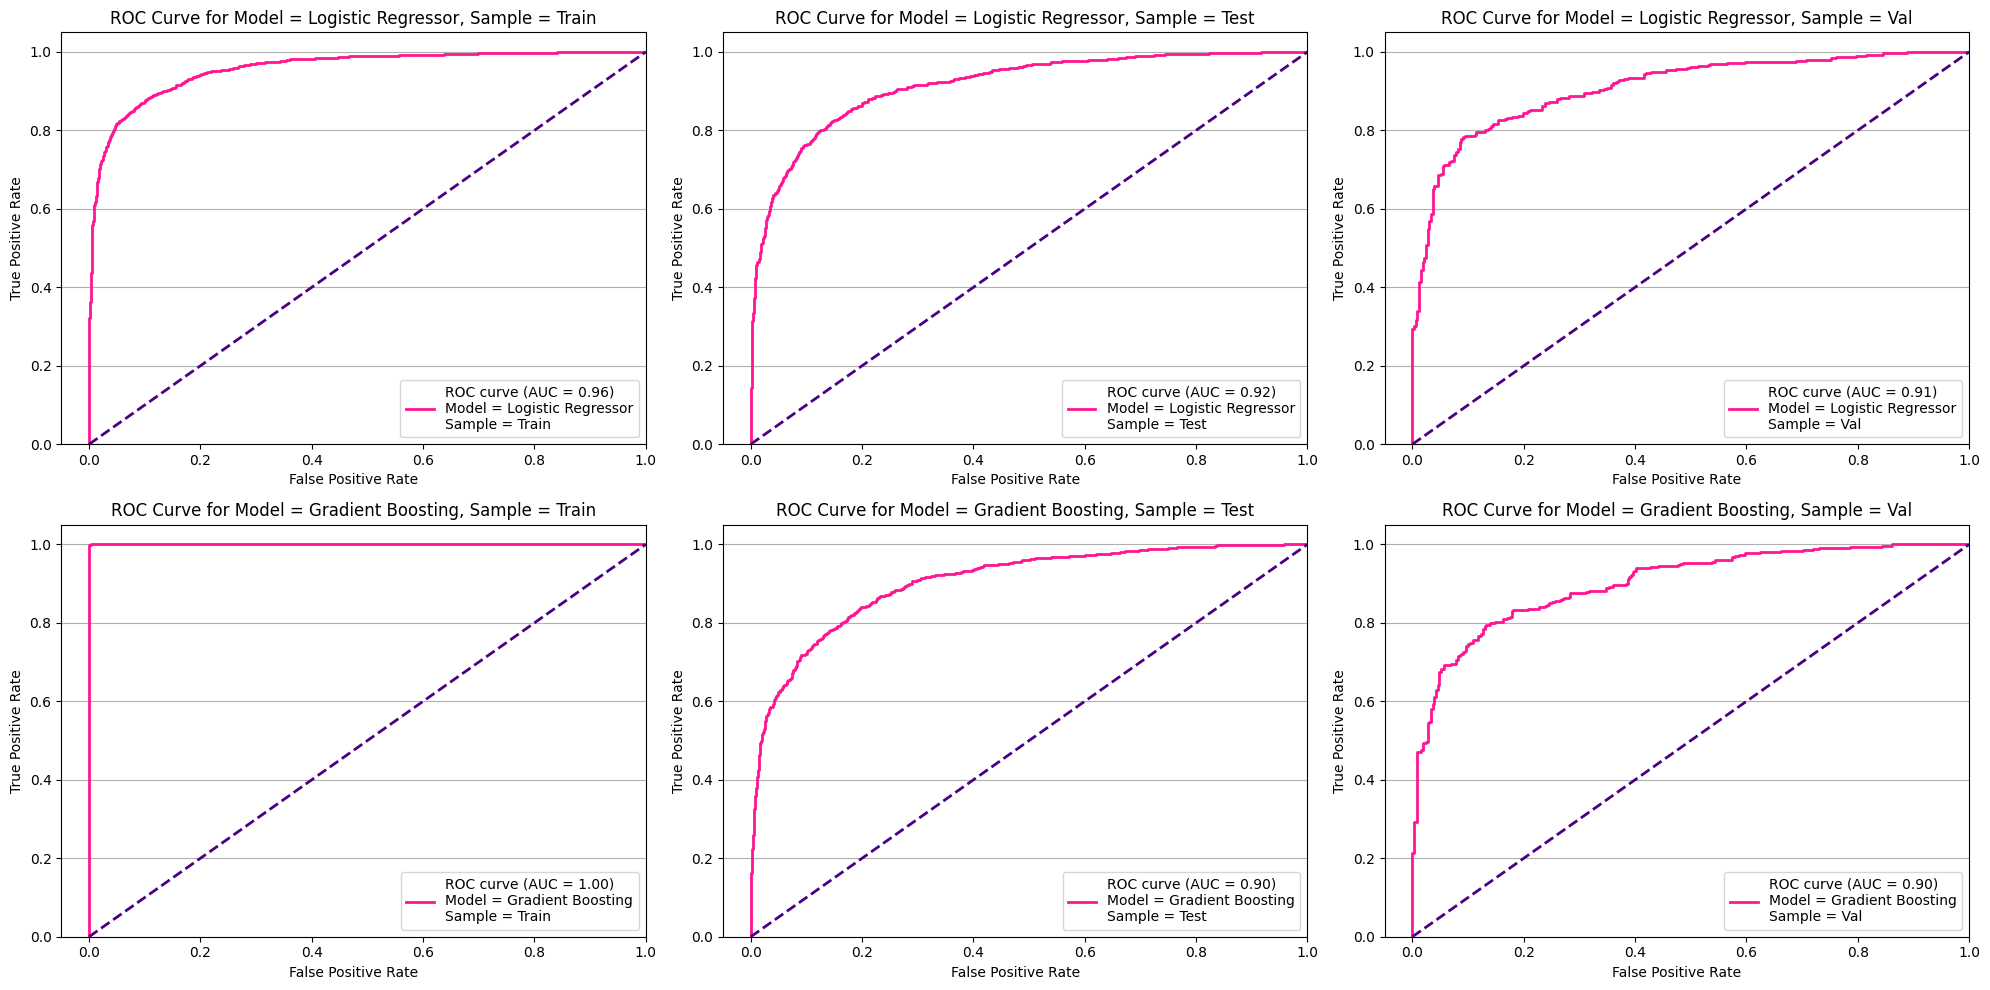

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.ravel()  # преобразуем в плоский массив для удобства

models = [
    (logistic_regression, 'TRAIN', (train.drop(['target', 'Sample'], axis=1), train['target']), ('Logistic Regressor', 'Train')),
    (logistic_regression, 'TEST', (test.drop(['target', 'Sample'], axis=1), test['target']), ('Logistic Regressor', 'Test')),
    (logistic_regression, 'VAL', (val.drop(['target', 'Sample'], axis=1), val['target']), ('Logistic Regressor', 'Val')),
    (boosting, 'TRAIN', (train_pool, train['target']), ('Gradient Boosting', 'Train')),
    (boosting, 'TEST', (test_pool, test['target']), ('Gradient Boosting', 'Test')),
    (boosting, 'VAL', (val_pool, val['target']), ('Gradient Boosting', 'Val')),
]

for model, ax_i in zip(models, ax):
    
    y_score = model[0].predict_proba(model[2][0])[:, 1]
    
    fpr, tpr, _ = roc_curve(model[2][1], y_score)
    roc_auc = auc(fpr, tpr)
    
    ax_i.plot(fpr, tpr, color='deeppink', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})\nModel = {model[3][0]}\nSample = {model[3][1]}')
    
    ax_i.plot([0, 1], [0, 1], color='indigo', lw=2, linestyle='--')
    ax_i.set_xlim([-0.05, 1.0])
    ax_i.set_ylim([0.0, 1.05])
    ax_i.set_xlabel('False Positive Rate')
    ax_i.set_ylabel('True Positive Rate')
    ax_i.set_title(f'ROC Curve for Model = {model[3][0]}, Sample = {model[3][1]}')
    ax_i.legend(loc='lower right')
    ax_i.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [24]:
save_path = os.path.join(main_path, 'src/models')

assert os.path.exists(save_path)

with open(os.path.join(save_path, 'logreg_tonality(baseline).pkl'), 'wb') as f:
    pickle.dump(logistic_regression, f)

with open(os.path.join(save_path, 'catboost_tonality(baseline).pkl'), 'wb') as f:
    pickle.dump(boosting, f)